In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [14]:
!kaggle datasets download -d huan9huan/walk-or-run

walk-or-run.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
import zipfile
zip= zipfile.ZipFile("/content/walk-or-run.zip","r")
zip.extractall("/content")
zip.close()

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot  as plt

In [17]:
train_path = "/content/walk_or_run_train/train"
test_path = "/content/walk_or_run_test/test"

In [18]:
data_gen = ImageDataGenerator(rescale=1/255,validation_split=0.1)

In [19]:
train_ds = data_gen.flow_from_directory(directory=train_path,
                                                    target_size=(150, 150),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    subset='training')

val_ds = data_gen.flow_from_directory(directory=train_path,
                                                    target_size=(150,150),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    subset='validation')

test_ds = data_gen.flow_from_directory(directory=test_path,
                                                   target_size=(150,150),
                                                   batch_size=16,
                                                   class_mode='categorical',
                                                )

Found 541 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


In [39]:
import numpy as np

(16, 150, 150, 3)


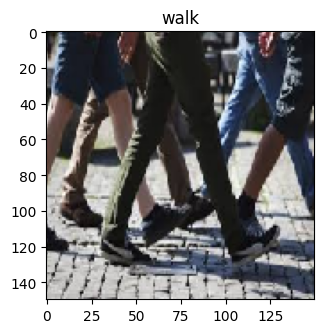

(16, 150, 150, 3)


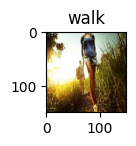

(16, 150, 150, 3)


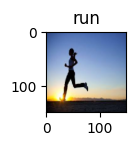

(16, 150, 150, 3)


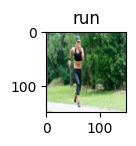

(16, 150, 150, 3)


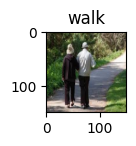

(16, 150, 150, 3)


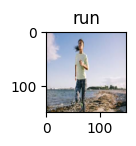

(16, 150, 150, 3)


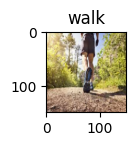

(16, 150, 150, 3)


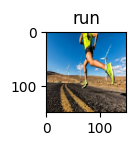

(16, 150, 150, 3)


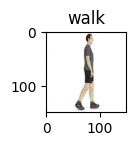

(16, 150, 150, 3)


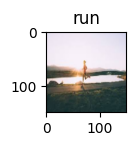

(16, 150, 150, 3)


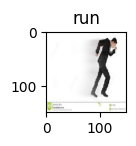

(16, 150, 150, 3)


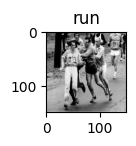

(13, 150, 150, 3)


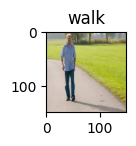

(16, 150, 150, 3)


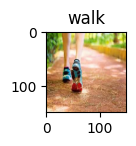

(16, 150, 150, 3)


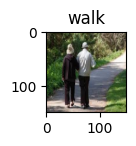

(16, 150, 150, 3)


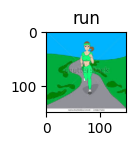

In [42]:
plt.figure(figsize=(16, 16))
classNames = ['run', 'walk']
for i in range(1,17):
    plt.subplot(4, 4, i)
    img, label =train_ds.next()
    print(img.shape)
    plt.title(classNames[np.argmax(label)])
    plt.imshow(img[0])
    plt.show()


# **Transfer Learning**

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [22]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [23]:
base_model.trainable = False

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

In [26]:
opt = optimizers.Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 23903010 (91.18 MB)
Trainable params: 2100226 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
__________

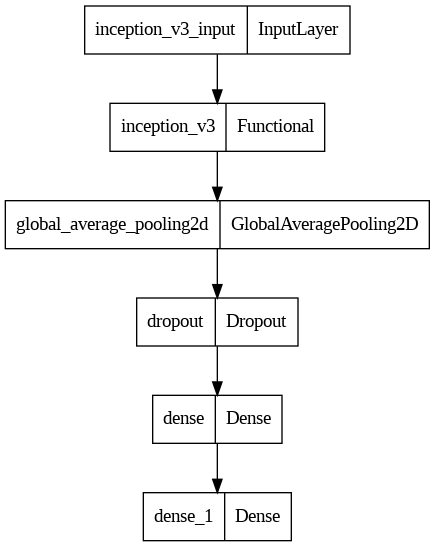

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [30]:
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.6118
Epoch 1: val_loss improved from inf to 0.50957, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 35s 857ms/step - loss: 0.8873 - accuracy: 0.6118 - val_loss: 0.5096 - val_accuracy: 0.7458
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7726
Epoch 2: val_loss did not improve from 0.50957
34/34 [==============================] - 26s 780ms/step - loss: 0.5117 - accuracy: 0.7726 - val_loss: 0.6121 - val_accuracy: 0.6441
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8207
Epoch 3: val_loss improved from 0.50957 to 0.43176, saving model to model.h5
34/34 [==============================] - 27s 798ms/step - loss: 0.3740 - accuracy: 0.8207 - val_loss: 0.4318 - val_accuracy: 0.7797
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9187
Epoch 4: val_loss did not improve from 0.43176
34/34 [==============================] - 28s 818ms/step - loss: 0.2515 - accuracy: 0.9187 - val_loss: 0.4938 - val_accuracy: 0.7458
Epoch 5/20
34/34 [=

In [31]:
import matplotlib.pyplot as plt

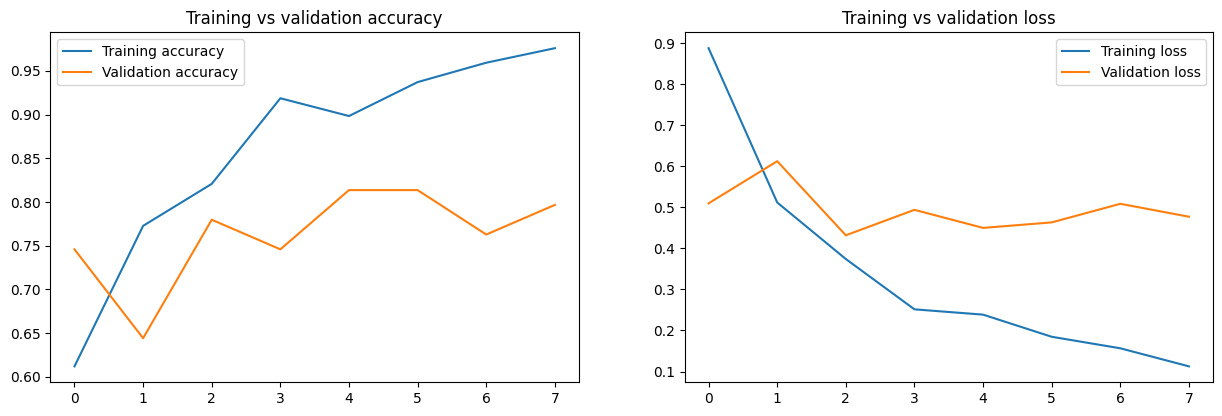

In [32]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [33]:
loss, accuracy = model.evaluate(x=test_ds)

9/9 [==============================] - 6s 587ms/step - loss: 0.4269 - accuracy: 0.7943


# Output

In [44]:
import cv2

In [114]:
img, label =test_ds.next()
test = img[0]

In [131]:
test2= cv2.imread("/content/walk_or_run_test/test/run/run_47e8074d.png")

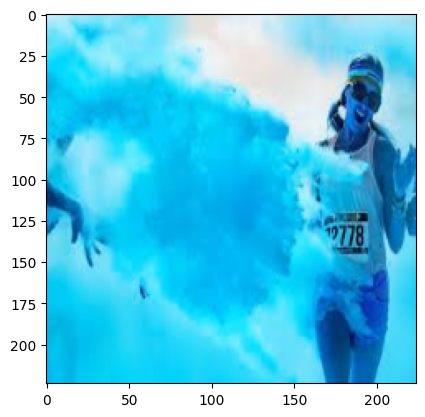

In [132]:
plt.imshow(test2)

In [133]:
test = cv2.resize(test2,(150,150))

In [134]:
result = model.predict(test.reshape(1,150, 150, 3)/255.)

1/1 [==============================] - 0s 135ms/step


In [135]:
labels = {0: 'run', 1: 'walk'}
predicted_class = labels[np.argmax(result[0], axis=-1)]

In [136]:
predicted_class

'run'